In [1]:
# source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [2]:
import glob
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion()

In [3]:
!wget -nc https://download.pytorch.org/tutorial/faces.zip

--2020-07-08 06:38:21--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.16.69, 52.84.16.73, 52.84.16.104, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.16.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M  --.-KB/s    in 0.1s    

2020-07-08 06:38:22 (46.3 MB/s) - ‘faces.zip’ saved [5780252/5780252]



In [4]:
!unzip -nq *.zip

In [5]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

r = np.random.randint(0,68)
img_name = landmarks_frame.iloc[r,0]
landmarks = landmarks_frame.iloc[r,1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype(np.float32).reshape(-1,2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 5 landmarks: {}'.format(landmarks[:5]))

Image name: 3152653555_68322314f3.jpg
Landmarks shape: (68, 2)
First 5 landmarks: [[ 88.  63.]
 [ 84.  83.]
 [ 82. 103.]
 [ 82. 124.]
 [ 85. 144.]]


In [6]:
# define a simple helper function to show an image and its landmarks
def show_landmarks(image, landmarks):
  """
    Show image with landmarks
  """
  plt.imshow(image)
  plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, marker = '.', c='r')
  plt.pause(0.001) # pause a bit so plots are updated

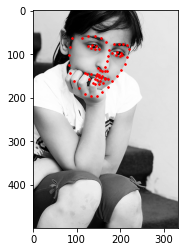

In [7]:
# test the function with a random example
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)

plt.show()

A custom dataset should inherit `Dataset` and override `__len__`,`__getitem__` methods. We use `__len__` to get the size of the data and `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i_{th}$ example.

In [8]:
class FaceLandmarksDataset(Dataset):
  """ Face Landmarks Dataset """

  def __init__(self, csv_file, root_dir, transform = None):
    """
    Args:
      csv_file (string): Path to the csv file with annotations.
      root_dir (string): Directory with all the images.
      transform (callable, optional): Optional transform to be applied on
        a sample.
    """
    self.landmarks_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.landmarks_frame)
  
  def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()
      
      img_name = os.path.join(self.root_dir,
                              self.landmarks_frame.iloc[idx, 0])
      image = io.imread(img_name)
      landmarks = self.landmarks_frame.iloc[idx, 1:]
      landmarks = np.array([landmarks])
      landmarks = landmarks.astype(np.float32).reshape(-1,2)
      sample = {'image': image, 'landmarks': landmarks}

      if self.transform:
        sample = self.transform(sample)
      
      return sample

0 (324, 215, 3) (68, 2)


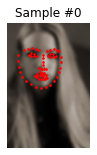

1 (500, 333, 3) (68, 2)


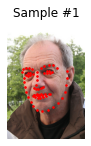

2 (250, 258, 3) (68, 2)


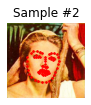

3 (434, 290, 3) (68, 2)


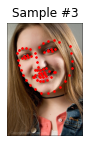

In [9]:
face_dataset = FaceLandmarksDataset(csv_file="faces/face_landmarks.csv",
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i]

  print(i, sample['image'].shape, sample['landmarks'].shape)

  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  show_landmarks(**sample)

  if i == 3:
    plt.show()
    break


In [91]:
# create custom transformers
class Rescale(object):
  """
  Rescale the image in a sample to a given size
  Args:
    output_size (tuple or int): Desired output size. If tuple,
      output is matched to output_size. If int, smaller of image edges
      is matched to output_size keeping aspect ratio the same.
  
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int,tuple))
    self.output_size = output_size
  
  def __call__(self,sample):
    image, landmarks = sample['image'], sample['landmarks']

    h, w = image.shape[:2]
    if isinstance(self.output_size,int):
      if h>w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w / h
    else:
      new_h, new_w = self.output_size
    
    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(image, (new_h, new_w))

    # h and w are swapper for landmarks because of images.
    # x and y axes are axis 1 and 0 respectively
    landmarks = landmarks * [new_w / w, new_h / h]
    
    return {'image':img, 'landmarks': landmarks}

class RandomCrop(object):
  """
  Crop randomly the image in a sample
  Doesn't crop the parts with face landmarks.
  """

  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']
    
    lm_min_x = sample['landmarks'][:,0].min()
    lm_max_x = sample['landmarks'][:,0].max()
    lm_min_y = sample['landmarks'][:,1].min()
    lm_max_y = sample['landmarks'][:,1].max()

    h, w = image.shape[:2]

    top = np.random.randint(lm_max_y+5, h)
    down = np.random.randint(0, lm_min_y-5)
    left = np.random.randint(0, lm_min_x-5)
    right = np.random.randint(lm_max_x+5, w)


    image = image[down: top,
                  left: right]

    landmarks = landmarks - [left,down]

    return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
  """ Convert ndarrays in sample to Tensors """

  def __call__(self,sample):
    image, landmarks = sample['image'], sample['landmarks']

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C x H x W
    image = image.transpose((2,0,1))

    return {'image': torch.from_numpy(image),
            'landmarks': torch.from_numpy(landmarks)}

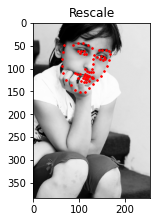

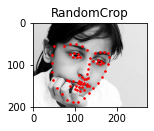

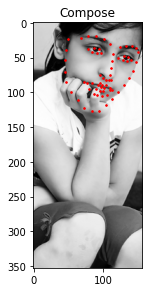

In [95]:
scale = Rescale(256)
crop = RandomCrop()
composed = transforms.Compose([Rescale(256),
                               RandomCrop()])

# Apply each of the above transforms on sample
fig = plt.figure()
sample = face_dataset[r]
for i, tsfrm in enumerate([scale, crop, composed]):
  transformed_sample = tsfrm(sample)

  ax = plt.subplot(1, 3, i + 1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_landmarks(**transformed_sample)

plt.show()